<h1 style="color:blue; margin-bottom:20px"> Исследование объявлений о продаже квартир</h1>

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

В рамках проекта выполним следущие шаги: 

1. [Выгрузка данных и изучение общей информации](#load)
2. [Предобработка данных](#prepararion)
3. [Расчет дополнительных показателей](#count)
4. [Исследовательский анализ данных](#research)
    - [Изучение площади, цены, числа комнат, высоты потолков](#papameters)
    - [Изучение времени продажи квартиры](#timeofselling)
    - [Очистка данных](#cleaning)
    - [Определить факторы, которые больше всего влияют на стоимость квартиры](#mainfactors)
    - [Выявление взаимосвязи между этажом квартиры и ценой, а также взаимосвязи этакжка квартиры и других факторов](#floor)
    - [Определить 10 населённых пунктов с наибольшим числом объявлений](#top10)
    - [Определить квартиры, которые находится в центре](#centre)
    - [Определить, влияют ли на стоимость квартир в центре те же факторы, что и в квартирах на окраине и в пригороде](#differes)
5. [Вывод](#conc)

<div style="border:solid blue 2px; padding: 20px"> 
<h1 style="color:blue; margin-bottom:20px">Шаг 1. Выгрузка данных и изучение общей информации</h1>

На данном этапе необходимо выгрузить данные, ознакомиться с кими в общих чертах, оценить, насколько много пропусков и что данные их себя предствляют.
<a id="load"></a>
</div>

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('Исследование_объявлений_о_продаже_квартир.csv', sep = '\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,nan,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,nan
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,nan,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,nan,0.00,nan,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,nan,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,nan,14.00,nan,9,NaN,...,nan,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,nan,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

 <div style="border:solid grey 1px; padding: 20px"> 
Данные в корректных форматах. Много пропущенных значений, изучим их подробнее
</div>

In [4]:
# Создали фрейм, в котором указано количество заполеннеых данных по показателям
filled_data = data.count().to_frame().reset_index() 
filled_data.columns = ['index', 'filled'] 

filled_data['empty']=len(data)-filled_data['filled'] # Рассчитали количество пропусков по показателям

# Рассчитали процент пропусков по показателям
filled_data['empty_percent'] = (1-(filled_data['filled']/len(data))).round(2) 
# Оставим только значения с пропусками
data_with_drops = filled_data.sort_values(by='empty_percent').query('filled < 23699')
data_with_drops # Создали фрем, где остались только показатели с пропусками

,index,filled,empty,empty_percent
14,locality_name,23650,49,0.00
6,floors_total,23613,86,0.00
7,living_area,21796,1903,0.08
12,kitchen_area,21421,2278,0.10
21,days_exposition,20518,3181,0.13
15,airports_nearest,18157,5542,0.23
16,cityCenters_nearest,18180,5519,0.23
17,parks_around3000,18181,5518,0.23
19,ponds_around3000,18181,5518,0.23
5,ceiling_height,14504,9195,0.39


 <div style="border:solid grey 1px; padding: 20px"> 
Наибольший объем данных пропущен в показателях, где есть пропуск с наибольшей долей вероятности означает отсутствие конкретного признака, например в столбце is_apartment пропуск скорее всего означает, что это не апартаменты, а пропуск в столбце parks_nearest означает что никакого парка рядом нет.

Конечно есть и такие столбцы, где пропуски сложно отнести тем или иным значениям так просто, например высоту потолков, где доля пропусков составляет 39%, а также расстояние до центра или аэропорта. Как поступать с такими пропусками решим при проведении дальнейшего анализа. 
   
</div>

<div style="border:solid grey 2px; padding: 20px"> 
<h1 style="color:grey; margin-bottom:20px">Вывод шаг 1</h1>

Датасет представлен довольно большим количеством объявлений о продаже недвижимости: 23 700 штук. Данные представлены в 23 столбцах. Судить о чистоте данных пока рано, но можно сказать, что пропусков не очень много, всего в 14 из 23 столбцов есть пропуски в принципе, во многих столбцах довольно легко предположить с чем может быть связан пропуск и как данные должны быть заполнены, где-то вполне реально оценить, а где то можно их удалить. Будем смотреть по конкретным случаям.
</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h1 style="color:blue; margin-bottom:20px">Шаг 2. Предобработка данных</h1>

На данном этапе необходимо произвести предобработку данных.Проверим данные на дубликаты, решим, что делать с пропусками, поменяем форматы данных, если это требуется.
<a id="prepararion"></a>  
</div>

In [5]:
columns_with_drops = data_with_drops['index'].unique().tolist()
# Создадим список столбцов с пропусками

In [6]:
data[columns_with_drops].head()

,locality_name,floors_total,living_area,kitchen_area,days_exposition,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,ceiling_height,balcony,ponds_nearest,parks_nearest,is_apartment
0,Санкт-Петербург,16.00,51.00,25.00,nan,18863.00,16028.00,1.00,2.00,2.70,nan,755.00,482.00,NaN
1,посёлок Шушары,11.00,18.60,11.00,81.00,12817.00,18603.00,0.00,0.00,nan,2.00,nan,nan,NaN
2,Санкт-Петербург,5.00,34.30,8.30,558.00,21741.00,13933.00,1.00,2.00,nan,0.00,574.00,90.00,NaN
3,Санкт-Петербург,14.00,nan,nan,424.00,28098.00,6800.00,2.00,3.00,nan,0.00,234.00,84.00,NaN
4,Санкт-Петербург,14.00,32.00,41.00,121.00,31856.00,8098.00,2.00,1.00,3.03,nan,48.00,112.00,NaN


In [7]:
data[columns_with_drops].describe()

,floors_total,living_area,kitchen_area,days_exposition,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,ceiling_height,balcony,ponds_nearest,parks_nearest
count,23613.00,21796.00,21421.00,20518.00,18157.00,18180.00,18181.00,18181.00,14504.00,12180.00,9110.00,8079.00
mean,10.67,34.46,10.57,180.89,28793.67,14191.28,0.61,0.77,2.77,1.15,517.98,490.80
std,6.60,22.03,5.91,219.73,12630.88,8608.39,0.80,0.94,1.26,1.07,277.72,342.32
min,1.00,2.00,1.30,1.00,0.00,181.00,0.00,0.00,1.00,0.00,13.00,1.00
25%,5.00,18.60,7.00,45.00,18585.00,9238.00,0.00,0.00,2.52,0.00,294.00,288.00
50%,9.00,30.00,9.10,95.00,26726.00,13098.50,0.00,1.00,2.65,1.00,502.00,455.00
75%,16.00,42.30,12.00,232.00,37273.00,16293.00,1.00,1.00,2.80,2.00,729.00,612.00
max,60.00,409.70,112.00,1580.00,84869.00,65968.00,3.00,3.00,100.00,5.00,1344.00,3190.00


In [8]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

 <div style="border:solid grey 1px; padding: 20px"> 
Видно, что апартаментов не так много, наиболее вероятно что пропущенные данные - это случаи, в которых люди просто не стали заполнять поля, т.к. данная недвижимость не апартаменты
   
</div>

In [9]:
data['is_apartment']=data['is_apartment'].fillna(False)
# Заменили пропуски на False

In [10]:
data[data['parks_nearest'].isnull()]['parks_around3000'].value_counts()

0.00    10102
Name: parks_around3000, dtype: int64

In [11]:
data[data['parks_around3000'].isnull()]['parks_nearest'].value_counts()


Series([], Name: parks_nearest, dtype: int64)

 <div style="border:solid grey 1px; padding: 20px"> 
Проверили пересечения по показателям, связанным с парками, вдруг были данные, где наличие парка рядом не указано, а расстояние указано, и наоборот. Таких не оказалось
</div>

In [12]:
data[data['ponds_nearest'].isnull()]['ponds_around3000'].value_counts()

0.00    9071
Name: ponds_around3000, dtype: int64

In [13]:
data[data['ponds_around3000'].isnull()]['ponds_nearest'].value_counts()


Series([], Name: ponds_nearest, dtype: int64)

 <div style="border:solid grey 1px; padding: 20px"> 
С парками аналогично....
</div>

 <div style="border:solid grey 1px; padding: 20px">  
Можно достаточно спокойно заменить проспуски в значениях по наличию прудов и парков заменить на нули, а данные с расстояниями трогать не будем. Это не результирующие данные, чтобы их удалять, а оценить мы их врят ли сможем

</div>

In [14]:
data['ponds_around3000']=data['ponds_around3000'].fillna(0)
data['parks_around3000']=data['parks_around3000'].fillna(0)

In [15]:
data['balcony'] = data['balcony'].fillna(0)

 <div style="border:solid grey 1px; padding: 20px"> 
Предположим, что в пропущенных данных по балкону ничего не указано, т.к. балконов нет
</div>

In [16]:
data['locality_name'] = data['locality_name'].fillna('Неизвестно')

 <div style="border:solid grey 1px; padding: 20px"> 
По неуказанным локациям так и поставим "Неизвестно"
</div>

 <div style="border:solid grey 1px; padding: 20px"> 
Проведем оценку пропущенныз значений в столбцах:
    
    - floors_total
    - kitchen_area
    - living_area

Пропущенных данных по этим значения не так много и они не являются наиболее важными для проведения анализа, так что внесенные мной изменения даже в случае не полной корректности не будут нести тотального ущерба для резултатов анализа. Кроме того, эти данные попробуем достаточно объективно

*Данные по **days_expositions** я оценивать не буду, т.к. это один из ключевых факторово, тут важнее те цифры которые есть реально, чем моя оценка.*

*Оставим данные в исходном виде и в столбцах cityCenters_nearest и airports_nearest. Это не результирующие данные, чтобы их удалять, а оценить мы их врят ли сможем сейчас.*

*Также оставим в без изменений данные по ceiling_height. Этот показатель лучше иметь в том виде, в котором он есть и из него лучше почерпнуть интересные данные в будующем.*


</div>

In [17]:
spb_median_floor = data[data['locality_name']=='Санкт-Петербург']['floors_total'].median()
nonspb_median_floor = data[data['locality_name']!='Санкт-Петербург']['floors_total'].median()
print('Медианная этажность в Санкт-Петербурге составляет {:.0f} этажей'.format(spb_median_floor))
print('Медианная этажность за пределами Санкт-Петербурга составляет {:.0f} этажей'.format(nonspb_median_floor))

Медианная этажность в Санкт-Петербурге составляет 9 этажей
Медианная этажность за пределами Санкт-Петербурга составляет 5 этажей


In [18]:
#заменили данные на медианные по населенным пунктам
data.loc[(data['floors_total'].isnull()) & (data['locality_name'] == 'Санкт-Петербург'), 'floors_total']= spb_median_floor
data.loc[(data['floors_total'].isnull()) & (data['locality_name'] != 'Санкт-Петербург'), 'floors_total']= nonspb_median_floor

In [19]:
def square(arrea):
    if arrea > 300:
        return 'огромное'
    if arrea > 70:
        return 'большое'
    if arrea > 45:
        return 'среднее'
    if arrea > 30:
        return 'меньше среднего'
    return 'маленькое'
 # Для замен разобьём жилье по категориям в зависимости от площади

In [20]:
data['square_category'] = data['total_area'].apply(square)
data['square_category'].value_counts()

среднее            8858
меньше среднего    8204
большое            5677
маленькое           899
огромное             61
Name: square_category, dtype: int64

In [21]:
data['med_ar'] = data['living_area']/data['total_area']
median_living_arrea_perc = data['med_ar'].median()
print('Медианная доля жилой площади составляет:{:.2%}'.format(median_living_arrea_perc))

Медианная доля жилой площади составляет:56.79%


 <div style="border:solid grey 1px; padding: 20px"> 
Рассчитаем медианное значение доли жилой площади в кваритарах в зависимости от категории
</div>

In [22]:
# Определили функцию, которая рассчитывает медианное значение доли жилой площади в кваритарах в зависимости 
# от категории
def liv_area_perc(category):
    mid_part = data[data['square_category'] == category]['med_ar'].median() 
    return print('Медианная доля жилой площади в жилье категории {} составляет: {:0.2%}'.format(category, mid_part))

In [23]:
for i in data['square_category'].unique().tolist():
    liv_area_perc(i)

Медианная доля жилой площади в жилье категории большое составляет: 59.46%
Медианная доля жилой площади в жилье категории меньше среднего составляет: 50.40%
Медианная доля жилой площади в жилье категории среднее составляет: 59.51%
Медианная доля жилой площади в жилье категории маленькое составляет: 58.62%
Медианная доля жилой площади в жилье категории огромное составляет: 58.45%


In [24]:
data.loc[data['living_area'].isna(), 'living_area'] = data.loc[data['living_area'].isna(), 'total_area']\
* median_living_arrea_perc
# заменили значения living_area

 <div style="border:solid grey 1px; padding: 20px">  
Колебания доли жилой площади от изменения категории площади квартир крайне несущественные, при этом у маленьких квартир % жилой части наибольший, что странно. Поэтому для замены взяли медиану по всем данным
</div>

In [25]:
data['med_kitchen'] = data['kitchen_area']/data['total_area']
median_kitchen_arrea_perc = data['med_kitchen'].median()
print('Медианная доля жилой площади составляет:{:.2%}'.format(median_kitchen_arrea_perc))

Медианная доля жилой площади составляет:17.24%


 <div style="border:solid grey 1px; padding: 20px">  
Рассчитаеи медианное значение доли жилой площади в кваритарах в зависимости от категории
</div>

In [26]:
# Определили функцию, которая рассчитывает медианное значение доли площади кухни в кваритарах 
# в зависимости от категории
def kitch_area_perc(category):
    mid_part = data[data['square_category'] == category]['med_kitchen'].median() 
    print('Медианная доля площади кухни в жилье категории {} составляет: {:0.2%}'.format(category, mid_part))
    return mid_part

In [27]:
# заменили пропуски по слолбцу kitchen_area на произведение медианной доли площади кухни 
# по категории и жилой площади
data.loc[(data['kitchen_area'].isnull()) & (data['square_category'] == 'маленькое'), 'kitchen_area'] = data.loc[(data['kitchen_area'].isnull()) & (data['square_category'] == 'маленькое'), 'total_area'] * kitch_area_perc('маленькое')
data.loc[(data['kitchen_area'].isnull()) & (data['square_category'] == 'меньше_среднего'), 'kitchen_area'] = data.loc[(data['kitchen_area'].isnull()) & (data['square_category'] == 'меньше_среднего'), 'total_area'] * kitch_area_perc('меньше_среднего')
data.loc[(data['kitchen_area'].isnull()) & (data['square_category'] == 'среднее'), 'kitchen_area'] = data.loc[(data['kitchen_area'].isnull()) & (data['square_category'] == 'среднее'), 'total_area'] * kitch_area_perc('среднее')
data.loc[(data['kitchen_area'].isnull()) & (data['square_category'] == 'большое'), 'kitchen_area'] = data.loc[(data['kitchen_area'].isnull()) & (data['square_category'] == 'большое'), 'total_area'] * kitch_area_perc('большое')
data.loc[(data['kitchen_area'].isnull()) & (data['square_category'] == 'огромное'), 'kitchen_area'] = data.loc[(data['kitchen_area'].isnull()) & (data['square_category'] == 'огромное'), 'total_area'] * kitch_area_perc('огромное')

Медианная доля площади кухни в жилье категории маленькое составляет: 21.43%
Медианная доля площади кухни в жилье категории меньше_среднего составляет: nan%
Медианная доля площади кухни в жилье категории среднее составляет: 15.65%
Медианная доля площади кухни в жилье категории большое составляет: 13.81%
Медианная доля площади кухни в жилье категории огромное составляет: 8.74%


 <div style="border:solid grey 1px; padding: 20px"> 
Тут уже динамика очень заметна изменения доли площади кухни в зависимости от площади жилья видна. Чем больше квартира, тем меньше доля кухни. Замены были сделаны по категриям
</div>

In [28]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M')
# Привели даты к формату datetime64[ns]

In [29]:
data['floors_total'] = data['floors_total'].astype('int64')
data['balcony'] = data['balcony'].astype('int64')
data['parks_around3000'] = data['parks_around3000'].astype('int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('int64')
# Привели целочисленные признаки с типу int64

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          22989 non-null  float64       
 13  balcony         

In [31]:
data[data.duplicated()]
# полностью дублирующихся строк нет

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_category,med_ar,med_kitchen


<div style="border:solid grey 2px; padding: 20px"> 

<h1 style="color:grey; margin-bottom:20px">Вывод. Предобработка данных</h1>

По результатам предобработки данных мы изучили подробно 14 столбцов. Ниже представлены решения, которые были приняты в отношении каждого из эти столбцов. Мотивация решения по каждогму конкретному можно увидеть в комментиариях к коду.

- is_apartment: заменили на False;
- ponds_around3000, parks_around3000, balcony: заменили на 0;
- ponds_nearest, parks_nearest, cityCenters_nearest, airports_nearest, days_exposition, ceiling_height : оставали в исходном виде;
- locality_name: проставили "Неизвестно" для пустых значений;
- floors_total, kitchen_area, living_area:произвели оценку

Таким образом из 14 столбцов с пропусками мы смогли тем или иным способом заполнить данные в 8 и еще 6 оставили в изначальном виде.
Некорректные форматы были только в 5 столбцах, и то большинство это ошибки, когда вместо типа int использовался float, что не очень страшно.

В целом данные сложно назвать чистыми. Если бы это была внутрянняя база какой-нибудь компании, то их можно было бы счиатать дейсвительно грязными. Например, если бы это было информаци по квартирам, которые продает застройщик. Но так как это данные с сервиса, где люди сами оставляют информаци, то ничего удивительно в пропусках нет. И пропусков в таком контексте не так уж и много. Люди по большей части заполняют важную для формирования цены информаци, а всякие нюансы или то, что не добавит недвижимости стоимость, опускают

К сожалению, нельзя достаточно объективно оценить количество дублирующихся заявок. Нет какого то уникального ID для каждого объявления, что не дает нам определить дубли по формальному признаку. Если говорить о фактически одном и том же объявлении, то в явном виде строк, где все данные дублируются нет. Но понятно есть данные вроде расстояния до аэропорта, где можно изменить уисло не единицу и по строке уже не будет дубля. Более конкретных же данных не очень достаточно. Если искать дубли только по этажу, названию города, общей этажности и площади, мы найдем очень много дублей, которые не будут ими фактически. Нужна хотя бы разбика по по райнам или улицам. 
</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h1 style="color:blue; margin-bottom:20px">Шаг 3. Расчет дополнительных показателей</h1>

На данном этапе необходимо рассчитать следующие показатели:
- цену квадратного метра;
- день недели, месяц и год публикации объявления;
- этаж квартиры; варианты — первый, последний, другой;
- соотношение жилой и общей площади, а также отношение площади кухни к общей
<a id="count"></a>     
</div>

In [32]:
data['price_met'] = data['last_price']/data['total_area']
data[['last_price', 'total_area', 'price_met']].head()#рассчитали цену квадратного метра

,last_price,total_area,price_met
0,13000000.00,108.00,120370.37
1,3350000.00,40.40,82920.79
2,5196000.00,56.00,92785.71
3,64900000.00,159.00,408176.10
4,10000000.00,100.00,100000.00


In [33]:
print('Средння цена квадратного метра в Санкт-Петербурге составляет {:.2f} рублей'\
      .format(data[data['locality_name'] == 'Санкт-Петербург'].price_met.mean()))
#рассчитали среднюю цену за кв.м. по Питеру
print('Средння цена квадратного метра за пределами Санкт-Петербурга составляет {:.2f} рублей'\
      .format(data[data['locality_name'] != 'Санкт-Петербург'].price_met.mean()))
#рассчитали среднюю цену за кв.м. по Питеру

Средння цена квадратного метра в Санкт-Петербурге составляет 114849.01 рублей
Средння цена квадратного метра за пределами Санкт-Петербурга составляет 69021.38 рублей


In [34]:
def floor_cat(floor_liv):
    if floor_liv['floor'] == 1:
        return 'первый'
    if floor_liv['floor'] == floor_liv['floors_total']:
        return 'последний'
    return 'другое'
#Определили функцию, которая будет определять категорию этажа
data['floor_cat'] = data.apply(floor_cat, axis = 1)
# Созадали столбец с категорией этажа

In [35]:
floor_table = data.\
pivot_table(index = 'floor_cat', values = 'price_met', aggfunc = {'price_met':['count', 'mean']})\
.reset_index().sort_values(by = 'mean', ascending = False)

floor_table.columns = ['floor_cat','number_of_announcements','mean_price_for_meter']
floor_table

,floor_cat,number_of_announcements,mean_price_for_meter
0,другое,17439,103489.92
2,последний,3343,93415.22
1,первый,2917,81983.56


 <div style="border:solid grey 1px; padding: 20px"> 
Жилье на первых и последних этажа представлено чуть больше чкм в 25% объясвлений, также видно что жилье там в среднем дешевле чем на прочих этажах. Самое дешевое жилье на первом этаже
</div>

In [36]:
data['med_ar'] = data['living_area']/data['total_area']
data['med_kitchen'] = data['kitchen_area']/data['total_area']
data = data.rename(columns = {'med_ar': 'living_part', 'med_kitchen':'kitchen_part'})

 <div style="border:solid grey 1px; padding: 20px"> 
Данные по доли жилой площади и площади кухни уже были рассчитаны ранее, но мы их обновим, чтобы избавить от пропусков. Мы уже рассчитывали пропуски на основании эти данных, так что обновление ни на что не повлияет в расчетах
</div>

In [37]:
square_caragory_arrea = data.\
pivot_table(index = 'square_category', values = ['living_part', 'kitchen_part', 'last_price', 'days_exposition'], \
            aggfunc = 'median')\
.reset_index().sort_values(by = 'days_exposition', ascending = False)

square_caragory_arrea.rename(columns = {'living_part': 'median_living_part', 'kitchen_part':'median_kitchen_part'})

,square_category,days_exposition,median_kitchen_part,last_price,median_living_part
3,огромное,190.50,0.09,59800000.00,0.57
0,большое,138.00,0.14,9206000.00,0.59
4,среднее,93.00,0.16,5000000.00,0.59
2,меньше среднего,81.00,0.23,3590000.00,0.51
1,маленькое,63.00,0.21,2740000.00,0.57


 <div style="border:solid grey 1px; padding: 20px"> 
Как мы уже замечали ранее доля жилого пространства почти не меняется в зависимости от размера жилья, а вот доля кухни меняется заментно. Также можно заметить, что чем выше метраж квартиры, тем дороже она стоит, что логично. А вот скорость продажи жилье увеличивается с уменьшением площади
</div>

In [38]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['day'] = data['first_day_exposition'].dt.day
data['year'] = data['first_day_exposition'].dt.year
data['month'] = data['first_day_exposition'].dt.month
data[['weekday', 'day', 'year', 'month']].head()

,weekday,day,year,month
0,3,7,2019,3
1,1,4,2018,12
2,3,20,2015,8
3,4,24,2015,7
4,1,19,2018,6


In [39]:
weekday_table = data.\
pivot_table(index = 'weekday', values = 'price_met', aggfunc = {'price_met':['count', 'median']})\
.reset_index().sort_values(by = 'weekday', ascending = False)
weekday_table['median']=weekday_table['median'].round(2)

weekday_table.rename(columns = {'count': 'number_of_announcements', 'median':'median_price_for_meter'})

,weekday,number_of_announcements,median_price_for_meter
6,6,1699,94501.72
5,5,1936,93545.72
4,4,4000,94616.16
3,3,4295,95143.88
2,2,3974,95473.81
1,1,4183,95634.10
0,0,3612,94688.91


In [40]:
year_table = data.\
pivot_table(index = 'year', values = 'price_met', aggfunc = {'price_met':['count', 'median']})\
.reset_index().sort_values(by = 'year', ascending = False)
year_table['median']=year_table['median'].round(2)

year_table.rename(columns = {'count': 'number_of_announcements', 'median':'median_price_for_meter'})

,year,number_of_announcements,median_price_for_meter
5,2019,2879,103305.79
4,2018,8519,95689.66
3,2017,8190,92565.09
2,2016,2783,91743.12
1,2015,1191,93414.63
0,2014,137,107000.00


<div style="border:solid grey 2px; padding: 20px"> 

<h1 style="color:grey; margin-bottom:20px">Вывод. Расчет значений</h1>

Жилье на первых и последних этажа представлено чуть больше чем в 25% объясвлений, также видно что жилье там в среднем дешевле чем на прочих этажах (81 983 и  93 415 против 103 489 соответственно).

Доля кухни в среднем составляет 19%, но она сильно различается в зависимости от млощади жилья. Например в очень больших кваритраз она может быть всего лишь 9%, а в маленьком жилье составлять 20-25%. Доля же жилой площади, как правило, 56% от общей вне зависимости от категории.

В 2018 году также было опубликовано больше всего объйявлений - 8519, а объявления с самой высокой медианной ценой за квадратный метр были опубликованы в 2014 и 2019 гг.  ( 107 000  и 103 305 соответственно). Это были единственные два года, когда медианная цена за кв. м превысилы 100 тысяч.

Наиболее часто объявлени публиковали в понедельник(4 183), среду(4 295) и четверг(4 000).  Наиболее редко в субботу (1699). Но зависимость между ценой за квадратной метр и днем недели не наблюдается.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h1 style="color:blue; margin-bottom:20px">Шаг 4. Исследовательский анализ данных</h1>

На данном этапе необходимо произвести следующие действия:

- [изучить площадь, цену, число комнат, высоту потолков;](#papameters)
- [изучить время продажи квартиры;](#timeofselling)
- [убрать редкие и выбивающиеся значения;](#cleaning)
- [определить факторы, которые больше всего влияют на стоимость квартиры;](#mainfactors)
- [определить, влияет ли этаж квартиры на цену и на какие-либо другие факторы;](#floor)
- [определить 10 населённых пунктов с наибольшим числом объявлений;](#top10)
- [определить квартиры, которые находится в центре;](#centre)
- [определить, влияют ли на стоимость квартир в центре те же факторы, что и в квартирах на окраине и в пригороде
](#differes)
<a id="research"></a>   
</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 4.1 Изучение площади, цены, числа комнат, высоты потолков</h3>
<a id="papameters"></a>
</div>

In [41]:
data_main = data[['last_price', 'total_area', 'ceiling_height', 'rooms']]
data_main.head() #вывели изучаемы данные в отдельный DataFrame

,last_price,total_area,ceiling_height,rooms
0,13000000.00,108.00,2.70,3
1,3350000.00,40.40,nan,1
2,5196000.00,56.00,nan,2
3,64900000.00,159.00,nan,3
4,10000000.00,100.00,3.03,2


In [42]:
# Установим палитру
sns.set_palette('Dark2')

# Установим стиль
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.25)


In [43]:
def kde_box(dataframe, column):
    plt.figure(figsize = (10,5))

    ax1 = plt.subplot(1,2,1)
    sns.histplot(data=dataframe, x=column)#sns.distplot(dataframe[column].dropna())  sns.histplot(data=dataframe, x=column)
    plt.title('Hist-KDE plot of '+column)

    ax2 = plt.subplot(1,2,2)
    sns.boxplot(data = dataframe, y = column)
    plt.title('Boxplot of '+column)
    
    plt.subplots_adjust(right = 1)
    plt.show()
# Определили функцию которая будет выводить график плотности и боксплот по показателю

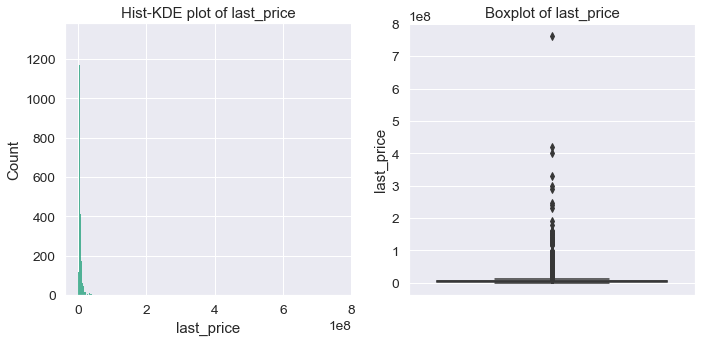

In [44]:
kde_box(data, 'last_price')

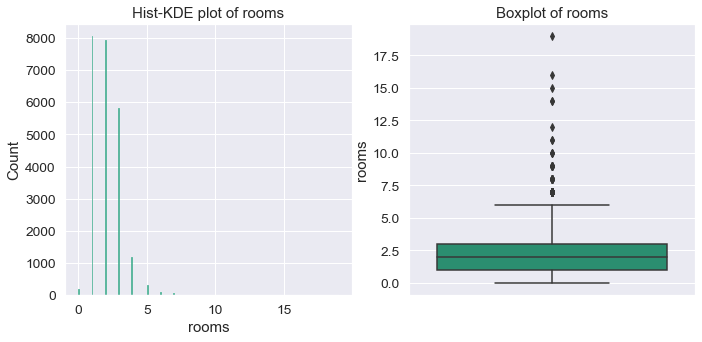

In [45]:
kde_box(data, 'rooms')

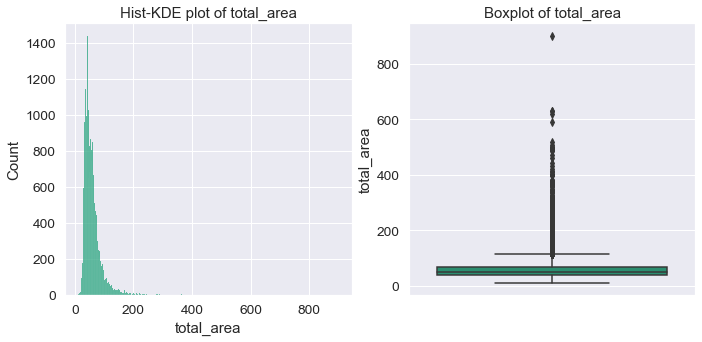

In [46]:
kde_box(data, 'total_area')

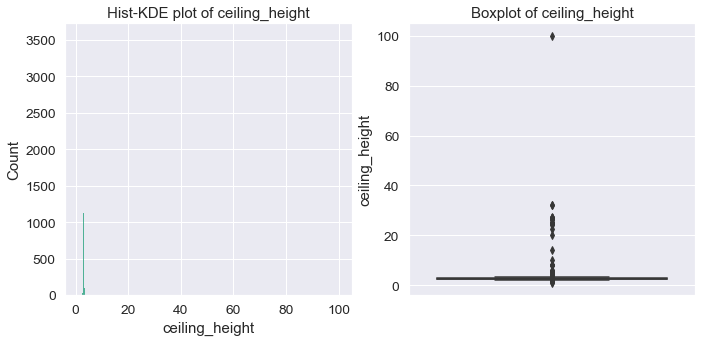

In [47]:
kde_box(data, 'ceiling_height')

In [48]:
data_main.describe()

,last_price,total_area,ceiling_height,rooms
count,23699.00,23699.00,14504.00,23699.00
mean,6541548.77,60.35,2.77,2.07
std,10887013.27,35.65,1.26,1.08
min,12190.00,12.00,1.00,0.00
25%,3400000.00,40.00,2.52,1.00
50%,4650000.00,52.00,2.65,2.00
75%,6800000.00,69.90,2.80,3.00
max,763000000.00,900.00,100.00,19.00


 <div style="border:solid grey 1px; padding: 20px"> 

По графикам плотности и боксплотам видно, что в данных довольно большое количество выбросов. Хоть эти данные и помогают нам понять полную картину, но выбросы будут мешать нам объективно оценить от чего зависит цена. Выбросы в нашей датасете - это по своей сути объявления, которые могут не поддаваться общей логике ценообразования, но при этом могут сильно влиять на корелляцию между показателями. Это также могут быть некоректно заполненные данные. Потому в при дальнейшем проведении исследования нам может понадобиться изабвиться от таких некорректных данных.

Почти все цены находиятся в диапазоне от 3 до 6 млн.рублей. Площадь квартир держится в диапазоне от 40 до 70 кв. метров. Высота потолков почти всегда одинакова и составляет 2.6-2.7 метра. Число комнат держится в диапазоне от 1 до 3.

Среди странных данных или выбросов мы можем увидеть недвижимость стоимостью 763 млн, хотя основная масса данных не превышвет 7 млн. Есть квартира площадью 900 кв. м., стоэтажный дом и квартира с 19 комнтамами. И есть квартиры с потолками как 1м так и 100.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue; margin-bottom:20px">Шаг 4.2 Изучение времени продажи квартиры</h3>
<a id="cotimeofsellingunt"></a>
</div>

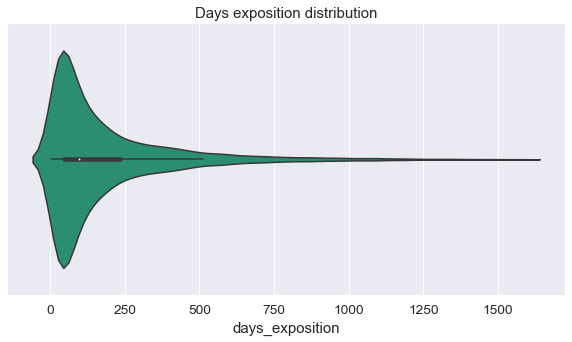

In [49]:
plt.figure(figsize =(10,5))

ax = sns.violinplot(
data = data,
x = 'days_exposition')
ax.set_title('Days exposition distribution')
plt.show()
# Отрисовали violinplot для days_exposition

In [50]:
data['days_exposition'].describe().to_frame().reset_index() 

,index,days_exposition
0,count,20518.00
1,mean,180.89
2,std,219.73
3,min,1.00
4,25%,45.00
5,50%,95.00
6,75%,232.00
7,max,1580.00


 <div style="border:solid grey 1px; padding: 20px"> 

Видно, что разброс значений достаточно большой. Стандартное отклоение 180. Максимальное количество дней продажи квартиры 1580 дней (около 4,5 года), хотя 75 процентиль всего 232 дня,а в полтора межквартильных размаза входят обЪявление с количеством дней, в течение которых они были выставлены на продажу составляет 500 дней.  Медиана очень отличается от средней, это связано как раз с тем, что существует ряд данных которые очень сильно отличаются от основных. Среднее количество дней продажи квартиры 180 при медиане 95 обозночает, что есть ряд данных, которые очень портят среднюю и данные скошены вправо.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue; margin-bottom:20px">Шаг 4.3 Очистка данных</h3>
<a id="cleaning"></a>
</div>

In [51]:
data.days_exposition.quantile(0.25)

45.00000000000001

In [52]:
data.days_exposition.max()

1580.0

In [53]:
def discrete_distributions(dataframe, column, kind):
    if dataframe[column].quantile(0.25) - 1.5*(dataframe[column].quantile(0.75) - dataframe[column].quantile(0.25))\
       <dataframe[column].min():
        qr1=dataframe[column].min()
    else:
        qr1 = dataframe[column].quantile(0.25) - 1.5*(dataframe[column].quantile(0.75) - dataframe[column].quantile(0.25))
    if dataframe[column].quantile(0.75) + 1.5*(dataframe[column].quantile(0.75) - dataframe[column].quantile(0.25))\
       >= dataframe[column].max():
        qr2=dataframe[column].max()
    else:
        qr2 = dataframe[column].quantile(0.75) + 1.5*(dataframe[column].quantile(0.75) - dataframe[column].quantile(0.25))
    
    qrs = [qr1, qr2]
    return qrs[kind-1]
# Определили функцию, которая возвращает нижнее или верхнее значение "уса" боксплота,

In [54]:
discrete_distributions(data, 'total_area', 2)

114.75000000000001

 <div style="border:solid grey 1px; padding: 20px"> 

Отсекать редкие в выбивающиеся значения будем по "усам" боксплота. А так же будем убирать нереальные значения

</div>

In [55]:
main_columns = ['last_price', 'total_area','rooms', 'ceiling_height', 'floors_total','days_exposition']
#  определили ключевые столбцы, которые будем чистить. Это столбцы, которые несут наиболее важную информацию и 
# которые в наибольшей степени влияют на цену  

In [56]:
data[main_columns].describe() #изучим распределение данных

,last_price,total_area,rooms,ceiling_height,floors_total,days_exposition
count,23699.00,23699.00,23699.00,14504.00,23699.00,20518.00
mean,6541548.77,60.35,2.07,2.77,10.67,180.89
std,10887013.27,35.65,1.08,1.26,6.59,219.73
min,12190.00,12.00,0.00,1.00,1.00,1.00
25%,3400000.00,40.00,1.00,2.52,5.00,45.00
50%,4650000.00,52.00,2.00,2.65,9.00,95.00
75%,6800000.00,69.90,3.00,2.80,16.00,232.00
max,763000000.00,900.00,19.00,100.00,60.00,1580.00


In [57]:
# Определили функцию для удаления выбросов
def delete_data(dataframe, column):
    return dataframe[((dataframe[column]<=discrete_distributions(dataframe, column, 2)) | (dataframe[column].isna()==True))\
                &((dataframe[column]>=discrete_distributions(dataframe, column, 1))| (dataframe[column].isna()==True))]

In [58]:
clear_data = delete_data(data, 'days_exposition')
clear_data = delete_data(clear_data, 'floors_total')
#clear_data = delete_data(clear_data, 'ceiling_height')
#clear_data = delete_data(clear_data, 'rooms')
clear_data = delete_data(clear_data, 'last_price')
clear_data = clear_data.query('total_area > 25 & total_area < 400 & rooms>0 & rooms <10')
clear_data = clear_data[((clear_data['ceiling_height'] <= 10) | (clear_data['ceiling_height'].isna()==True)) &\
                       (clear_data['ceiling_height'] >= 2.2) | (clear_data['ceiling_height'].isna()==True)]
# удалили выбросы и неадекватные значения

In [59]:
clear_data[main_columns].describe()

,last_price,total_area,rooms,ceiling_height,floors_total,days_exposition
count,19769.00,19769.00,19769.00,11969.00,19769.00,17179.00
mean,4829338.47,53.29,1.94,2.69,10.67,126.25
std,2169625.72,18.40,0.89,0.25,6.53,120.09
min,12190.00,25.07,1.00,2.25,1.00,1.00
25%,3350000.00,39.30,1.00,2.50,5.00,40.00
50%,4400000.00,49.50,2.00,2.60,9.00,82.00
75%,5990000.00,63.10,3.00,2.75,16.00,180.00
max,11640000.00,230.00,7.00,8.30,29.00,512.00


In [60]:
print('Объем данных, который был изначально:{}'.format(data.last_price.count()))

print('Объем данных после очистки:{}'.format(clear_data.last_price.count()))

print('Данных ушло:{}'.format(data.last_price.count()-clear_data.last_price.count()))
print('Осталось данных ушло:{:.2%}'.format(clear_data.last_price.count()/data.last_price.count()))

Объем данных, который был изначально:23699
Объем данных после очистки:19769
Данных ушло:3930
Осталось данных ушло:83.42%


<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue; margin-bottom:20px">Шаг 4.4 Определение факторов, которые больше всего влияют на стоимость квартиры</h3>
<a id="mainfactors"></a>   
</div>

In [61]:
analysis_columns = ['last_price','days_exposition','total_area', 'rooms', 'ceiling_height', 'floors_total',\
                    'parks_around3000', 'ponds_around3000', 'cityCenters_nearest', 'total_images','price_met']

print('Всего отобрали {} параметров'.format(len(analysis_columns)))
#'floor_cat', 'balcony',

Всего отобрали 11 параметров


In [62]:
clear_data[analysis_columns].corr()

,last_price,days_exposition,total_area,rooms,ceiling_height,floors_total,parks_around3000,ponds_around3000,cityCenters_nearest,total_images,price_met
last_price,1.00,0.04,0.68,0.44,0.40,0.21,0.25,0.28,-0.34,0.16,0.63
days_exposition,0.04,1.00,0.09,0.07,0.07,-0.05,0.02,0.02,0.00,0.01,-0.04
total_area,0.68,0.09,1.00,0.80,0.31,-0.03,0.08,0.11,-0.12,0.09,-0.09
rooms,0.44,0.07,0.80,1.00,0.10,-0.23,0.06,0.04,-0.08,0.07,-0.23
ceiling_height,0.40,0.07,0.31,0.10,1.00,-0.03,0.21,0.20,-0.26,0.01,0.22
floors_total,0.21,-0.05,-0.03,-0.23,-0.03,1.00,-0.14,-0.04,-0.04,0.02,0.35
parks_around3000,0.25,0.02,0.08,0.06,0.21,-0.14,1.00,0.37,-0.11,0.02,0.27
ponds_around3000,0.28,0.02,0.11,0.04,0.20,-0.04,0.37,1.00,-0.01,-0.00,0.27
cityCenters_nearest,-0.34,0.00,-0.12,-0.08,-0.26,-0.04,-0.11,-0.01,1.00,-0.04,-0.39
total_images,0.16,0.01,0.09,0.07,0.01,0.02,0.02,-0.00,-0.04,1.00,0.13


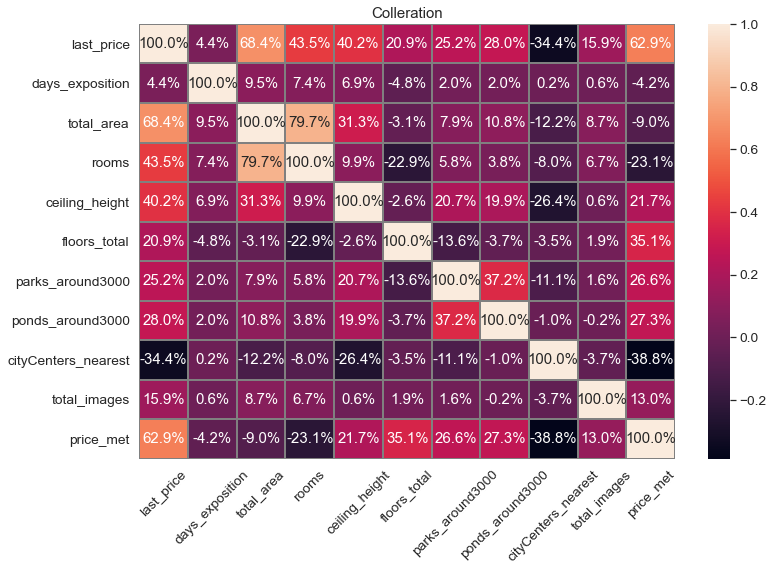

In [63]:
plt.figure(figsize = (12,8))
plt.title('Colleration')
sns.heatmap(clear_data[analysis_columns].corr(), annot=True, fmt='.1%', linewidths=1, linecolor='grey')
plt.xticks(rotation = 45)
plt.show()

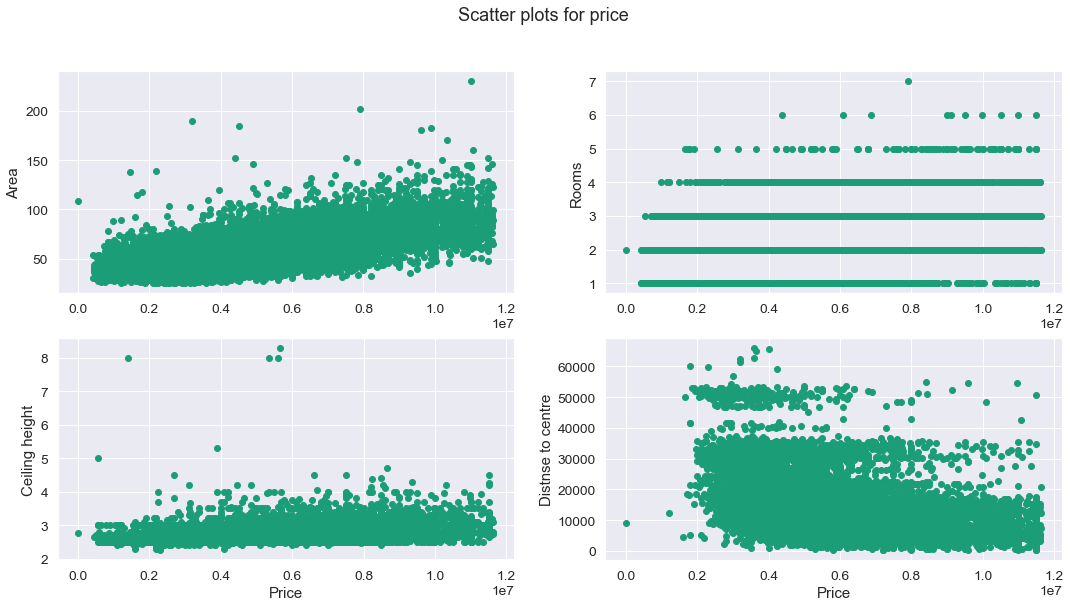

In [64]:
plt.figure(figsize = (18,9))

ax1 = plt.subplot(2,2,1)
plt.scatter(clear_data['last_price'], clear_data['total_area'])
plt.xlabel('')
plt.ylabel('Area')

ax2 = plt.subplot(2,2,2)
plt.scatter(clear_data['last_price'], clear_data['rooms'])
plt.xlabel('')
plt.ylabel('Rooms')

ax3 = plt.subplot(2,2,3)
plt.scatter(clear_data['last_price'], clear_data['ceiling_height'])
plt.xlabel('Price')
plt.ylabel('Ceiling height')

ax4 = plt.subplot(2,2,4)
plt.scatter(clear_data['last_price'], clear_data['cityCenters_nearest'])
plt.xlabel('Price')
plt.ylabel('Distnse to centre')

plt.suptitle('Scatter plots for price')
plt.show()

#clear_data.plot(x = 'last_price', y = 'total_area', kind='scatter', alpha=0.5, title = 'Last_price - total_area scatter plot')

 <div style="border:solid grey 1px; padding: 20px"> 

Наиболее сильная положительная корелляция наблюдаеся между ценой и общей площадью (68%), а также числом комнат и высотой потолков (43% и 40% соответственно). Наиболее сильная отрицательная корелляция наблюдается между ценой и удаленностью от центра (34%).

На точечных графиках очень хорошо видно, как что дорогих квартир с маленькой площадью почти нет, также очень заметно что среди дороги квартир почти нет тех, что расположены былее чем в 20 км от центра.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue; margin-bottom:20px">Шаг 4.5 Выявление взаимосвязи между этажом квартиры и ценой, а также взаимосвязи этажка квартиры и других факторов</h3>
<a id="floors"></a>
</div>

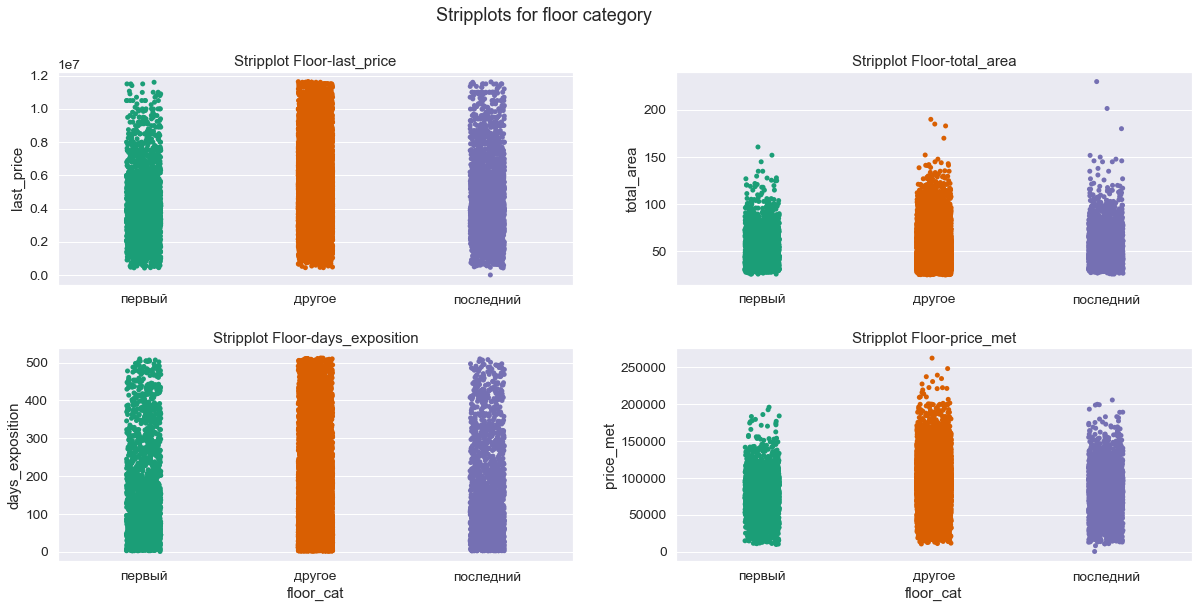

In [65]:
plt.figure(figsize = (18,9))

ax1 = plt.subplot(2,2,1)
plt.title('Stripplot Floor-last_price')
sns.stripplot(x = "floor_cat", y = "last_price", data = clear_data)
plt.xlabel('')

ax2 = plt.subplot(2,2,2)
plt.title('Stripplot Floor-total_area')
sns.stripplot(x = "floor_cat", y = "total_area", data = clear_data)
plt.xlabel('')

ax3 = plt.subplot(2,2,3)
plt.title('Stripplot Floor-days_exposition')
sns.stripplot(x = "floor_cat", y = "days_exposition", data = clear_data)

ax4 = plt.subplot(2,2,4)
plt.title('Stripplot Floor-price_met')
sns.stripplot(x = "floor_cat", y = "price_met", data = clear_data)

#plt.tight_layout()
plt.subplots_adjust(right = 1, hspace = 0.3)
plt.suptitle('Stripplots for floor category')
plt.show()

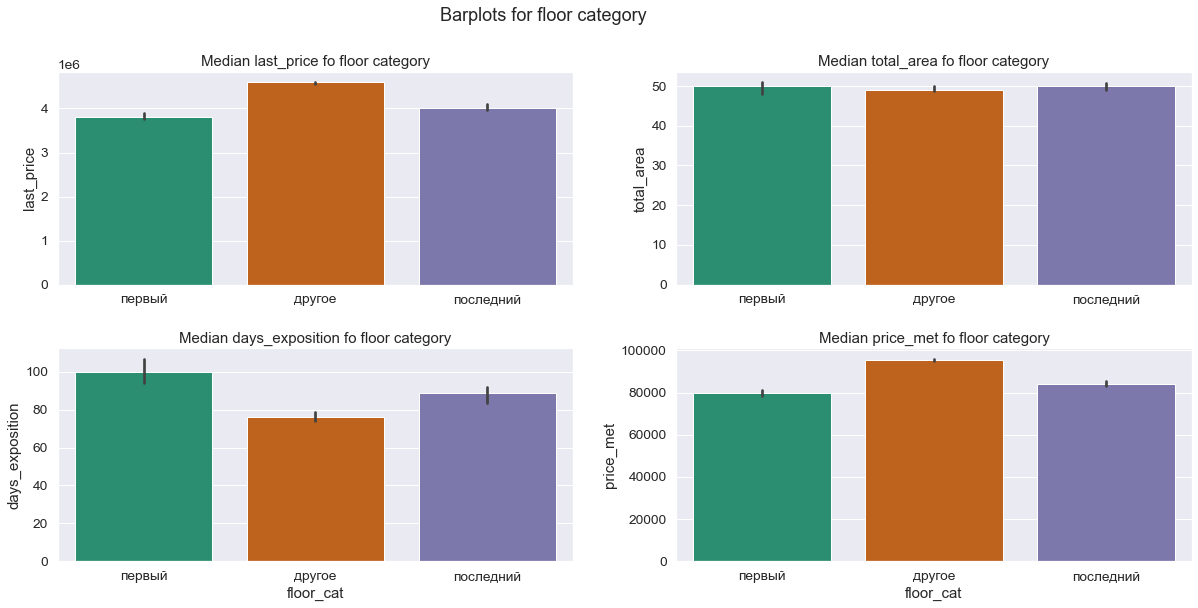

In [66]:
plt.figure(figsize = (18,9))

ax1 = plt.subplot(2,2,1)
plt.title('Median last_price fo floor category')
sns.barplot(x="floor_cat", y="last_price", data=clear_data, estimator=np.median)
plt.xlabel('')

ax2 = plt.subplot(2,2,2)
plt.title('Median total_area fo floor category')
sns.barplot(x="floor_cat", y="total_area", data=clear_data, estimator=np.median)
plt.xlabel('')

ax3 = plt.subplot(2,2,3)
plt.title('Median days_exposition fo floor category')
sns.barplot(x="floor_cat", y="days_exposition", data=clear_data, estimator=np.median)

ax4 = plt.subplot(2,2,4)
plt.title('Median price_met fo floor category')
sns.barplot(x="floor_cat", y="price_met", data=clear_data, estimator=np.median)

#plt.tight_layout()
plt.subplots_adjust(right = 1, hspace = 0.3)
plt.suptitle('Barplots for floor category')
plt.show()

 <div style="border:solid grey 1px; padding: 20px"> 

На графике распределения видно, что квартиры, которе расположены на первом и последнем этаже редко бывают такими же дорогими как и  те, что находятся между первым и последнем этажом. Разница также хорошо прослеживается на графике, где указаны цены за квадратный метр в зависимости от категории этажа.

Интересно, что среди квартир, которые расположены не на первом или последнем этаже, также больше всего тех квартир, которые долго продаются, скорее всего это связано с тем, что на точечном графике разница не очень хорошо видна, т.к. квартир которые между этажами значительно больше. В связи с этим мы построили столбчатые диаграммы с медианным значением каждого показателя.

Теперь хорошо видно, что квартиры между первым и последним этажом продаются значительно быстрее остальных (менее 80 дней при 100 днях на первом этаже и 90 на последнем). Медианная цена за квадратный метр также значительно выше (более 95 тыс. при 80 тыс. на первом этаже и 85 на последнем.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue; margin-bottom:20px">Шаг 4.6 Определение 10 населённых пунктов с наибольшим числом объявлений</h3>
<a id="top10"></a> 
</div>

In [67]:
top_cities = clear_data\
.pivot_table(index = 'locality_name', values = 'price_met', aggfunc = {'price_met':['count', 'mean']})\
.reset_index().sort_values(by = 'count', ascending = False)

top_cities.columns = ['locality_name','number_of_advertisments', 'mean_price_for meter']

top_cities.head(10)

,locality_name,number_of_advertisments,mean_price_for meter
34,Санкт-Петербург,12554,105090.75
286,посёлок Мурино,449,84859.15
320,посёлок Шушары,411,77959.52
3,Всеволожск,356,67200.87
13,Колпино,321,74994.02
33,Пушкин,311,99938.48
291,посёлок Парголово,309,90006.43
6,Гатчина,280,68594.91
92,деревня Кудрово,242,92113.59
4,Выборг,214,57609.93


In [68]:
top_cities.loc[top_cities["number_of_advertisments"] < 200, "locality_name"]= 'Прочие'
#Заменим города с количеством заявок меньше 200
top_cities=top_cities.pivot_table(index = 'locality_name', values = 'number_of_advertisments', aggfunc = 'sum')\
.reset_index().sort_values(by = 'number_of_advertisments', ascending = False)
#Сгруппируем все "Прочие" и посчитаем их количество

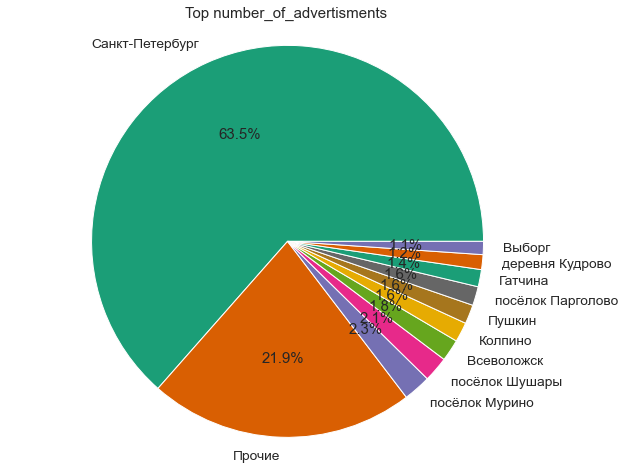

In [69]:
plt.figure(figsize = (10,8))

plt.pie(top_cities['number_of_advertisments'], labels = top_cities['locality_name'], autopct = '%0.1f%%')
plt.axis('equal')
plt.title('Top number_of_advertisments')
#plt.savefig('my_pie_chart.png')
plt.show()

 <div style="border:solid grey 1px; padding: 20px"> 

Подавляющее большинство квартир находятся в Санк-Петербурге (67%). Все остальные распределены по разным населенным пунткам Ленинградской области, населенные пункты, которые занимаю второе и третье места по количеству объясвлений: поселки Мурино и Шушары, но там всего по 2% объявлений. С полной десяткой можно ознакомиться в таблице чуть выше.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue; margin-bottom:20px">Шаг 4.7 Определение квартир, которые находится в центре</h3>
<a id="centre"></a>   
</div>

In [70]:
clear_data['km'] = clear_data['cityCenters_nearest']/1000#привел к километрам
clear_data['km'] = clear_data['km'].round()#округлил
clear_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,square_category,living_part,kitchen_part,price_met,floor_cat,weekday,day,year,month,km
1,7,3350000.00,40.40,2018-12-04,1,nan,11,18.60,1,False,...,меньше среднего,0.46,0.27,82920.79,первый,1,4,2018,12,19.00
4,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,большое,0.32,0.41,100000.00,другое,1,19,2018,6,8.00
5,10,2890000.00,30.40,2018-09-10,1,nan,12,14.40,5,False,...,меньше среднего,0.47,0.30,95065.79,другое,0,10,2018,9,nan
6,6,3700000.00,37.30,2017-11-02,1,nan,26,10.60,6,False,...,меньше среднего,0.28,0.39,99195.71,другое,3,2,2017,11,19.00
7,5,7915000.00,71.60,2019-04-18,2,nan,24,40.66,22,False,...,большое,0.57,0.26,110544.69,другое,3,18,2019,4,12.00


In [71]:
data_km = clear_data.pivot_table(index='km', values = 'last_price', aggfunc = {'last_price':['mean', 'median']}).reset_index()
data_km.columns = ['km','mean_price','median_price']
data_km.head()

,km,mean_price,median_price
0,0.00,8398000.00,7600000.00
1,1.00,8212671.04,8450000.00
2,2.00,7895941.18,8200000.00
3,3.00,7329868.61,7300000.00
4,4.00,7552947.14,7500000.00


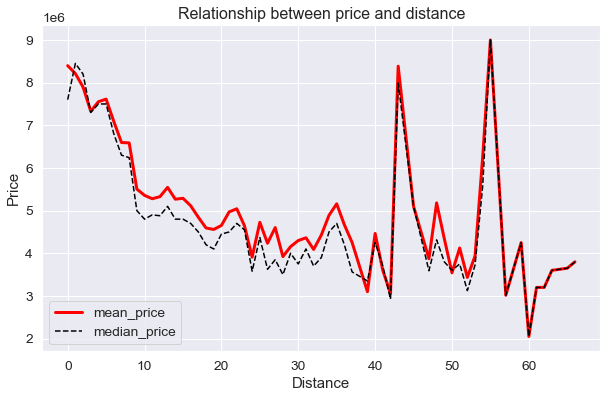

In [72]:
plt.figure(figsize = (10,6))

plt.plot(data_km['km'], data_km['mean_price'], color = 'red', linewidth=3.0)
plt.plot(data_km['km'], data_km['median_price'], color = 'black', linestyle = '--')
plt.xlabel('Distance')
plt.ylabel('Price')
plt.legend(['mean_price', 'median_price'])

plt.title('Relationship between price and distance',fontsize=16)
plt.show()

 <div style="border:solid grey 1px; padding: 20px"> 

Сильный пик на 43 и 55 км. Также рост идет когда расстояние до центра становится менее 10 км

</div>

In [73]:
clear_data[clear_data['km']==9]['locality_name'].value_counts()

Санкт-Петербург    472
Неизвестно           5
Name: locality_name, dtype: int64

In [74]:
clear_data[clear_data['km']==43][['km','last_price','locality_name']]

,km,last_price,locality_name
5659,43.00,11067416.00,посёлок Репино
17162,43.00,6100000.00,Сестрорецк
19984,43.00,7990000.00,Сестрорецк


In [75]:
clear_data[clear_data['km']==55][['km','last_price','locality_name']]

,km,last_price,locality_name
376,55.00,8400000.00,Зеленогорск
6247,55.00,9600000.00,Зеленогорск


In [76]:
def place(distance):
    if distance<=10:
        return 'centre'
    else:
        return 'outskirts'

In [77]:
clear_data['locality_type'] = clear_data['km'].apply(place)

In [78]:
clear_data.loc[clear_data["locality_name"] != 'Санкт-Петербург', "locality_type"]= 'suburb'

 <div style="border:solid grey 1px; padding: 20px"> 

Резкий рост рост цен начинается после расстояния до центра в 10 километров, установим именно это расстояние как центральную зону. Определенный рост заметен и после 20, но это явно еще далеко до центра. Также заметны два резких всплеска цены примерно на 43 и 55 километрах. Вполне вероятно что в этих местах находятся либо какие-то элитные поселки, либо там может находиться отдельная дорогая квартира.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue; margin-bottom:20px">Шаг 4.8 Определить, влияют ли на стоимость квартир в центре те же факторы, что и в квартирах на окраине и в пригороде</h3>
<a id="differes"></a>   
</div>

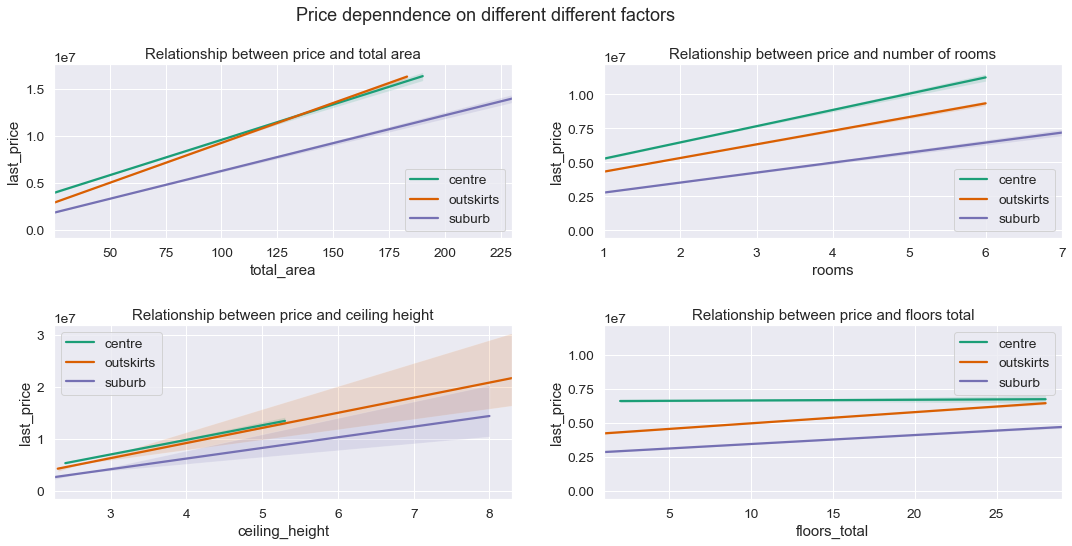

In [79]:
plt.figure(figsize = (16,8)) 

ax1 = plt.subplot(2,2,1)
sns.regplot(x="total_area", y="last_price", data=clear_data.query('locality_type == "centre"'), marker='o', scatter_kws={'s':0})
sns.regplot(x="total_area", y="last_price", data=clear_data.query('locality_type == "outskirts"'), marker='o', scatter_kws={'s':0})
sns.regplot(x="total_area", y="last_price", data=clear_data.query('locality_type == "suburb"'), marker='o', scatter_kws={'s':0})
#plt.ylim(10, 150)
plt.legend(['centre','outskirts','suburb'])
plt.title('Relationship between price and total area')

ax2 = plt.subplot(2,2,2)
sns.regplot(x="rooms", y="last_price", data=clear_data.query('locality_type == "centre"'), marker='o', scatter_kws={'s':0})
sns.regplot(x="rooms", y="last_price", data=clear_data.query('locality_type == "outskirts"'), marker='o', scatter_kws={'s':0})
sns.regplot(x="rooms", y="last_price", data=clear_data.query('locality_type == "suburb"'), marker='o', scatter_kws={'s':0})
plt.legend(['centre','outskirts','suburb'])
plt.title('Relationship between price and number of rooms')
    
ax3 = plt.subplot(2,2,3)
sns.regplot(x="ceiling_height", y="last_price", data=clear_data.query('locality_type == "centre"'), marker='o', scatter_kws={'s':0})
sns.regplot(x="ceiling_height", y="last_price", data=clear_data.query('locality_type == "outskirts"'), marker='o', scatter_kws={'s':0})
sns.regplot(x="ceiling_height", y="last_price", data=clear_data.query('locality_type == "suburb"'), marker='o', scatter_kws={'s':0})
plt.legend(['centre','outskirts','suburb'])
plt.title('Relationship between price and ceiling height')
    
ax4 = plt.subplot(2,2,4)
sns.regplot(x="floors_total", y="last_price", data=clear_data.query('locality_type == "centre"'), marker='o', scatter_kws={'s':0})
sns.regplot(x="floors_total", y="last_price", data=clear_data.query('locality_type == "outskirts"'), marker='o', scatter_kws={'s':0})
sns.regplot(x="floors_total", y="last_price", data=clear_data.query('locality_type == "suburb"'), marker='o', scatter_kws={'s':0})
plt.legend(['centre','outskirts','suburb'])
plt.title('Relationship between price and floors total')
    
plt.subplots_adjust(right = 1, hspace = 0.5)
plt.suptitle('Price depenndence on different different factors')
plt.show()

 <div style="border:solid grey 1px; padding: 20px"> 

На стоимость квартир в центре те же факторы, что и в квартирах на окраине и в пригороде, причем степень их влияния примерно одинаковая. Однако, есть небольшие различия, так общая облощадь жилья немного больше влияет на цену жилья на окраине, чем в центре, но число комнат немного важнее для квартир в центре чем на окраине. Хотя различия несущественны.

Из существенных различий видно, что на цену квартир в центре почти не влияет этажность, такое же влияние на квартиры загородом есть, но тоже невелико, а вот квартиры на окраине демонстирую уже заметную зависимомость от количества этажей. Это может быть связано не совсем с тем, что люди предпочитают именно многоэтажное жилье, а скорее с тем, что многоэтажные дома как правило более новые, в то врем как малоэтажное жилье, например пятиэтажки, довольно старое.

</div>

<div style="border:solid grey 2px; padding: 20px"> 

<h2 style="color:grey; margin-bottom:20px">Вывод. Исследовательский анализ данных</h2>

При проведении исследовательского анализа данных мы выявили следующие закономерности:
 
 1. Почти все цены находиятся в диапазоне от 3 до 6 млн.рублей. Площадь квартир держится в диапазоне от 40 до 70 кв. метров. Высота потолков почти всегда одинакова и составляет 2.6-2.7 метра. Число комнат держится в диапазоне от 1 до 3.
 2. Среди странных данных или выбросов мы можем увидеть недвижимость стоимостью 763 млн, хотя основная масса данных не превышвет 7 млн. Есть квартира площадью 900 кв. м., стоэтажный дом и квартира с 19 комнтамами. И есть квартиры с потолками как 1м так и 100м.
 3. Среднее количество дней продажи квартиры составляет 180 дней, медианное время продажи квартир - 95, значит основная масса квартир продается примерно за 3 месяца, однако есть какие-то квартиры, которые продаются гораздно дольше.  Максимальное количество дней продажи квартиры - 1580 дней.

Далее мы провели очистку данных от вбросов и сомнительных значений. К выбрсам отнесли все значения, которые выходят за пределы полутора межквартильных размаха.

4. Наиболее сильная положительная корелляция наблюдаеся между ценой и общей площадью (68%), а также числом комнат и высотой потолков (43% и 40% соответственно). Наиболее сильная отрицательная корелляция наблюдается между ценой и удаленностью от центра (34%)

5.  Квартиры между первым и последним этажом продаются значительно быстрее остальных (менее 80 дней при 100 днях на первом этаже и 90 на последнем). Медианная цена за квадратный метр также значительно выше (более 95 тыс. при 80 тыс. на первом этаже и 85 на последнем.

6. Подавляющее большинство квартир находятся в Санк-Петербурге (67%). Все остальные распределены по разным населенным пунткам Ленинградской области, населенные пункты, которые занимаю второе и третье места по количеству объясвлений: поселки Мурино и Шушары, но там всего по 2% объявлений

7. Резкий рост рост цен начинается после расстояния до центра в 10 километров, эту зону обозначили как центральную

8. В целом, на стоимость квартир в центре влияютте же факторы, что и в квартирах на окраине и в пригороде, причем степень их влияния примерно одинаковая. 

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h1 style="color:blue; margin-bottom:20px">Вывод по проекту</h1>
Мы провели исследование объявлений о продаже квартир. В нашем распоряжении был архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 
    
Датасет представлен довольно большим количеством объявлений о продаже недвижимости: 23 700 штук. Данные представлены в 23 столбцах. Данные были достаточно "грязными", было много пропусков и выбросов, также необходимо было корректировать форматы данных. Из 14 столбцов с пропусками мы смогли тем или иным способом заполнить данные в 8 и еще 6 оставили в изначальном виде. Некорректные форматы были только в 5 столбцах, и то большинство это ошибки, когда вместо типа int использовался float, что не очень страшно.

Мы дополнительно рассчитали следующие показатели: 
- цену квадратного метра;
- день недели, месяц и год публикации объявления;
- этаж квартиры; варианты — первый, последний, другой;
- соотношение жилой и общей площади, а также отношение площади кухни к общей 

Выводы относительно данных:

1. Жилье на первых и последних этажа представлено чуть больше чем в 25% объясвлений, также видно что жилье там в среднем дешевле чем на прочих этажах (81 983 и 93 415 против 103 489 соответственно).

2. Доля кухни в среднем составляет 19%, но она сильно различается в зависимости от млощади жилья. Например в очень больших кваритраз она может быть всего лишь 9%, а в маленьком жилье составлять 20-25%. Доля же жилой площади, как правило, 56% от общей вне зависимости от категории.

3. В 2018 году также было опубликовано больше всего объйявлений - 8519, а объявления с самой высокой медианной ценой за квадратный метр были опубликованы в 2014 и 2019 гг. ( 107 000 и 103 305 соответственно). Это были единственные два года, когда медианная цена за кв. м превысилы 100 тысяч.

3. Наиболее часто объявлени публиковали в понедельник(4 183), среду(4 295) и четверг(4 000). Наиболее редко в субботу (1699). Но зависимость между ценой за квадратной метр и днем недели не наблюдается.

4. Почти все цены находиятся в диапазоне от 3 до 6 млн.рублей. Площадь квартир держится в диапазоне от 40 до 70 кв. метров. Высота потолков почти всегда одинакова и составляет 2.6-2.7 метра. Число комнат держится в диапазоне от 1 до 3.

5. Среди странных данных или выбросов мы можем увидеть недвижимость стоимостью 763 млн, хотя основная масса данных не превышвет 7 млн. Есть квартира площадью 900 кв. м., стоэтажный дом и квартира с 19 комнтамами. И есть квартиры с потолками как 1м так и 100м.

6. Среднее количество дней продажи квартиры составляет 180 дней, медианное время продажи квартир - 95, значит основная масса квартир продается примерно за 3 месяца, однако есть какие-то квартиры, которые продаются гораздно дольше. Максимальное количество дней продажи квартиры - 1580 дней.

7. Также была проведена "очистка данных". Были удалены выбросы и сомнительные значения. К выбрсам отнесли все значения, которые выходят за пределы полутора межквартильных размаха.

8. Наиболее сильная положительная корелляция наблюдаеся между ценой и общей площадью (68%), а также числом комнат и высотой потолков (43% и 40% соответственно). Наиболее сильная отрицательная корелляция наблюдается между ценой и удаленностью от центра (34%)

9. Квартиры между первым и последним этажом продаются значительно быстрее остальных (менее 80 дней при 100 днях на первом этаже и 90 на последнем). Медианная цена за квадратный метр также значительно выше (более 95 тыс. при 80 тыс. на первом этаже и 85 на последнем.

10. Подавляющее большинство квартир находятся в Санк-Петербурге (67%). Все остальные распределены по разным населенным пунткам Ленинградской области, населенные пункты, которые занимаю второе и третье места по количеству объясвлений: поселки Мурино и Шушары, но там всего по 2% объявлений

11. Резкий рост рост цен начинается после расстояния до центра в 10 километров, эту зону обозначили как центральную

12. В целом, на стоимость квартир в центре влияютте же факторы, что и в квартирах на окраине и в пригороде, причем степень их влияния примерно одинаковая.

<a id="conc"></a>   
</div>

plt.subplots(figsize = (15,5))

visits.pivot_table(
    index='start_day', 
    columns='source id', 
    values='uid', 
    aggfunc='nunique').plot(title = 'Уникальные посещения по источникам', ax = plt.subplot(1,3,1))
plt.xticks(rotation = 45)

(visits.pivot_table(
    index='start_day', 
    columns='device', 
    values='uid', 
    aggfunc='nunique').plot(title = 'Уникальные посещения по девайсам', ax = plt.subplot(1,3,2)))
plt.xticks(rotation = 45)

(visits.groupby('start_day').agg({'uid':'nunique'}).plot(title = 'Уникальные посещения по девайсам', ax = plt.subplot(1,3,3)))
plt.xticks(rotation = 45)
plt.show() #Созадли 3 графика, по которым смотрим количество уникальных пользователей по источникам трафика, девайсам и в целом
 в разреще дней

#sns.distplot(data['ceiling_height'])
#sns.distplot(data['airports_nearest'], dropna=True)
#data.plot(y = 'ceiling_height', kind = 'hist')

In [80]:
#sns.pairplot(clear_data[result_columns], hue = 'locality_type')
#plt.title('')
#plt.show()

In [81]:
#'last_price','days_exposition','total_area',
#sns.pairplot(clear_data[analysis_columns])

In [82]:
#sns.regplot(x="last_price", y="total_area", data=clear_data.query('locality_type == "centre"'), marker='o', scatter_kws={'s':10})
#sns.regplot(x="last_price", y="total_area", data=clear_data.query('locality_type == "outskirts"'), marker='o', scatter_kws={'s':10})
#sns.regplot(x="last_price", y="total_area", data=clear_data.query('locality_type == "suburb"'), marker='o', scatter_kws={'s':10})
#plt.ylim(10, 150)
#plt.legend(['centre','outskirts','suburb'])
#plt.show()

In [83]:

#clear_data[clear_data['locality_type']=='centre'].plot(x = 'last_price', y = 'total_area', kind='scatter', alpha=0.8)
#clear_data[clear_data['locality_type']=='outskirts'].plot(x = 'last_price', y = 'total_area', kind='scatter', alpha=0.8)
#clear_data[clear_data['locality_type']=='suburb'].plot(x = 'last_price', y = 'total_area', kind='scatter', alpha=0.8)

In [84]:
#data_cetre = clear_data.query('locality_type == "centre"')
#data_outskirts = clear_data.query('locality_type == "outskirts"')
#data_suburb = clear_data.query('locality_type == "suburb"')



#plt.scatter(data_cetre['last_price'],data_cetre['total_area'],   alpha = 0.1)
#plt.scatter(data_outskirts['last_price'],data_outskirts['total_area'],   alpha = 0.1)
#plt.scatter(data_suburb['last_price'],data_suburb['total_area'],   alpha = 0.1)
#plt.xlabel('Last price')
#plt.ylabel('Total area')
#plt.title('Price distribution for total area')
#plt.show()

In [85]:
#clear_data[clear_data['locality_name']=='Зеленогорск'][['km','last_price','locality_name']].describe()

In [86]:
#clear_data[clear_data['km']==20][['km','last_price','locality_name', 'locality_type']]

In [87]:
#data[(data['last_price']<discrete_distributions(data, 'last_price', 2))\
#     &(data['last_price']>discrete_distributions(data, 'last_price', 1))]

In [88]:
#clear_data[clear_data['locality_type'] == 'suburb']['locality_name'].unique()

In [89]:
#data[(data['ceiling_height'] > discrete_distributions(data, 'ceiling_height', 1)) | (data['ceiling_height'].isna()==True)].info()

In [90]:
#def delete_data(dataframe, column):
#    return dataframe[(dataframe[column]<=discrete_distributions(dataframe, column, 2))\
#                &(dataframe[column]>=discrete_distributions(dataframe, column, 1))]